# Evolução Numérica da Métrica de Schwarzschild
## Aluno: Arthur Diniz Meirelles
## RA: 23202420703
## Maio de 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Aspectos Teóricos

Na relatividade numérica buscamos reformular as equações de campo de Einstein em uma forma que pode ser integrada numericamente. Para isso, decompomos a métrica $g_{ab}$ na sua métrica espacial $\gamma_{ab}$ e na chamada curvatura extrínseca $K_{ab}$:

\begin{align}
    \gamma_{ab}&=g_{ab}+n_an_b & K_{ab}&=-\gamma_a^c \gamma_b^d \nabla_c n_d
\end{align}

e usamos essas novas quantidades para reescrever as equações de campo e da geodésica na forma de equações diferenciais parciais de vínculo e de evolução denominadas equações ADM.

Essas equações, porém, possuem dois problemas:

- Para métricas com singularidades de coordenadas, o uso dessas equações pode levar a overflows e outros tipos de mal comportamento;
- Em geral, essas equações não são hiperbólicas, o que do ponto de vista numérico leva a instabilidade nas evoluções.

Por conta disso, não se resolve de forma única diretamente pelas equações ADM na sua forma geral qualquer sistema, busca-se primeiro a regularização e a hiperbolarização dessas equações para cada sistema. Sendo assim, uma única classe ou função genérica capaz de resolver qualquer problema de relatividade numérica não pode ser construída sem uma quantidade inconveniente de grandes blocos condicionais, e um software dedicado a resolver problemas diversificados nessa área tende a ser muito grande para o contexto desse projeto.

Por conta disso, eu apresentarei aqui de forma muito resumida uma abordagem que podemos usar para evoluir a métrica de Schwarzschild numericamente, uma situação física onde não acontece nada ao longo do tempo, mas que já pode mostrar como as quantidades numéricas necessárias para a evolução são sensíveis nesse problema.

Utilizamos a métrica de Schwarzschild em coordenadas isotrópicas:

$$ ds^2=-\alpha^2dt^2+\psi^4(dr^2+r^2d\Omega^2) $$

onde $\psi=1+M/2r$, onde $r$ está relacionado ao raio de Schwarschild como $r_s=r\psi^2$.

Seguindo a abordagem do livro Introduction to 3+1 Numerical Relativity de Miguel Alcubierre, temos as seguintes equações de evolução, ignorando termos de matéria:

\begin{equation}
    \partial_t \tilde{D}_A = -2\alpha(K_A D_\alpha + \partial_r K_A)
\end{equation}

\begin{equation}
    \partial_t \tilde{D}_B = -2\alpha(K_B D_\alpha + \partial_r K_B)
\end{equation}

\begin{equation}
        \partial_t K_A =
\end{equation}

\begin{equation}
        \partial_t K_B=
\end{equation}

\begin{equation}
    \partial_t \lambda = \frac{2\alpha \tilde{A}}{\tilde{B}}\left(\partial_r K_B-\frac{(\tilde{D}_B+4\partial_r\ln{\psi})(K_A-K_B)}{2}\right)
\end{equation}

onde (PREENCHER AQUI AS DEFINIÇÕES DAS VARIÁVEIS)

As equações de vínculo nessas condições são:

\begin{equation}
    \begin{split}
        H=&-\partial_rD_B-\frac{\lambda}{r}+AK_B(2K_A+K_B)\\
        &+\frac{1}{r}(D_A-3D_B)+\frac{D_AD_B}{2}-\frac{3D_B^2}{4}-8\pi A\rho=0
    \end{split}
\end{equation}
\begin{equation}
    M=-\partial_r K_B+(K_A-K_B)\left(\frac{1}{r}+\frac{D_B}{2}\right)-4\pi j_A=0
\end{equation}

e elas devem ser verdadeiras (dentro de um erro numérico) em todos os passos de tempo, por isso serão usadas para verificar se a integração está funcionando de forma precisa.

## Implementação

Eu consigo pensar em duas possíveis abordagens para a solução desse problema, que eu vou chamar de abordagens **direta** e **modular**, seguem suas características, vantagens e desvantagens:

- Abordagem direta: Como o nome indica, essa abordagem resolve o problema diretamente, linha a linha, no jupyter notebook, começando pela definição das condições iniciais, algumas funções feitas sob medida para a forma como eu estou definindo as variáveis e a chamada de loops de forma direta para a solução do problema. Uma abordagem comum em linguagens como C, onde não há orientação a objeto, que pode se mostrar eficiente em uso de memória por não precisar criar *instances* de classes próprias, além de ser mais fácil de implementar, pois não é necessário considerar o design de classes ou funções de forma que um usuário externo possa usar. O lado negativo é que, definidas as condições iniciais em uma célula específica, o código resolverá um único problema, e se eu quiser mudar qualquer coisa sobre o problema eu preciso mudar diretamente no código, e consequentemente o código não pode ser usado como módulo;
- Abordagem modular: A abordagem acima claramente quebra o conceito de importar esse código como um módulo. Uma abordagem modular conserta isso, definindo funções e - melhor ainda, mas não necessariamente - classes que tratam o problema de uma forma mais geral e portanto só precisam ser definidas uma vez e chamadas como quisermos posteriormente. Uma vantagem nítida é que podemos escrever a solução modular em um código, e em um script separado podemos fazer diversos testes, comparações e exemplos sem alterar o código principal. Essa é a abordagem "padrão" para o desenvolvimento de softwares em linguagens orientadas a objeto como Python e C++, especialmente para softwares disponibilizados publicamente, mas não é exclusiva a elas, muitos códigos em C podem por exemplo trabalhar exclusivamente com funções gerais a serem chamadas da forma "correta" por um usuário, as vezes por meio de scrips em bash. Ao contrário da abordagem anterior, porém, essa abordagem pode levar a uso maior de memória, e mais importante no contexto dessa atividade, exige uma implementação mais geral e portanto potencialmente complexa e sofisticada, permitindo interação com o usuário, generalização dos métodos, etc.

Meu interesse inicial era resolver o problema usando a segunda abordagem, mas somando a complexidade desse tipo de abordagem com a complexidade e não-generalidade do problema que eu escolhi tornou-a muito difícil, o que juntou-se ao fato de que eu terminei de estudar os requisitos para montar o projeto não muito tempo antes do prazo de entrega, tornando muito arriscado tentar essa abordagem. Por conta disso, estarei a seguir utilizando a primeira abordagem para resolver o problema, começando pela definição das propriedades do "grid" (unidimensional) e pela definição das condições iniciais, e a partir do formato dessas variáveis e funções, eu defino as funções necessárias para realizar a integração numérica, e finalmente crio um loop que realiza a integração para depois mostrar os resultados usando o matplotlib.

In [32]:
# This function defines the metric used:
def psi(r, M=1):
    # Isotropic coordinates function
    
    return 1+M/(2*r)

# Grid and simulation parameters:
Dr = 0.01
Dt = Dr/2
ti, tf = 0., 10.
M = 1.
rmin, rmax = 0., 10.
Nr = int((rmax-rmin)/Dr)
r = np.linspace(rmin, rmax, Nr)+Dr/2

# Extended r vector: A trick to approximate results around r=0 is to extend the functions
# to r = -\Delta r/2 as either an even or an odd function, so f(-\Delta r/2) = +/-f(\Delta r/2).
# Because the equations are 'regularized' at the origin, which is enforced by assuming local
# flatness at r ~ 0, this is a good approximation!

r_ext = np.zeros(Nr+1)
r_ext[1:] = r
r_ext[0] = -r_ext[1]

def extend_vec(vec, parity):
    # Given a vec numpy array (N,) and a parity (string = 'odd' or 'even'), returns the extended vector as either an odd or even function
    # of r. If odd, ext_vec[0] = -ext_vec[1], if even ext_vec[0]=ext_vec[1]
    ext_vec = np.zeros(len(vec)+1)

    if parity == 'odd':
        mult = -1.
    elif parity == 'even':
        mult = 1
    else:
        raise ValueError("parity (type = string) has to be either 'odd' or 'even'!")

    ext_vec[0] = mult*vec[0]
    ext_vec[1:] = vec

    return ext_vec

# Initial conditions:
tA, tB = 1.+np.zeros(Nr), 1.+np.zeros(Nr)
tDa, tDb = np.zeros(Nr), np.zeros(Nr)
Ka, Kb = np.zeros(Nr), np.zeros(Nr)

Imediatamente, precisamos de duas funções, uma para derivar e outra para integrar nossos vetores $V_r$ em relação a $r$. Para a derivada eu vou usar o algoritmo de diferença central e para as integrais a regra do trapézio, e na célula a seguir eu faço alguns testes dessas funções.

In [39]:
def d_dr(ext_vec, r, no_ext = False):
    '''
    Returns a np.array with the spatial derivatives 
    If given, bounds has to be a 2-element (number) list, tuple or array
    ext_vec (np.array (N, ) ): Extended vector to be differentiated ( with a value f(-dx/2)=+/-f(dx/2)
    '''
    
    if no_ext == True:
        # there are some derivatives in log functions that don't work with extensions
        diff = np.zeros(len(ext_vec))
        diff[-1] = (ext_vec[-1]-ext_vec[-2])/(r[-1]-r[-2])
        diff[0] = (ext_vec[1]-ext_vec[0])/(r[1]-r[0])

        # Central difference algorithm for numerical derivative:
        diff[1:-1] = (ext_vec[2:]-ext_vec[:-2])/(2*(r[2:]-r[:-2]))
    else:
        diff = np.zeros(len(ext_vec)-1)
        diff[-1] = (ext_vec[-1]-ext_vec[-2])/(r[-1]-r[-2])

        # Central difference algorithm for numerical derivative:
        diff[:-1] = (ext_vec[2:]-ext_vec[:-2])/(2*(r[1:]-r[:-1]))
        
    return diff

def int_dr(vec, r, bound):
    '''
    Returns a np.array with the spatial integral of vals, given an initial value integral[0]
    '''
        
    integral = np.zeros(len(vec))
    integral[0]=bound
    
    for i in range(len(vec)-1): #vectorized formula doesn't update the array dynamically
        integral[i+1]=integral[i]+0.5*(r[i+1]-r[i])*(vec[i]+vec[i+1]) #trapezoid rule

    return integral

In [33]:
# Test:
# The numerical implementation presented requires an artificial extension for each function
# Some of them are extended as even functions, while other are extended as odd functions

tA_ext = extend_vec(tA, 'even')

print('Derivative: ', d_dr(tA_shift, r))
print('Integral: ', int_dr(tA, r, 0))

Derivative:  [99.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   

Agora precisamos definir as funções de incremento temporal das nossas variáveis:

In [49]:
# reminder:
# even functions: tA, tB, Ka, Kb
# odd functions: lbda, Dalpha, Da, Db

# Though the variables are tDa and tDb, using Da and Db parity (both odd)
# is important, so I'll convert tDa -> Da and tDb -> Db before any derivation
# and keep using the "vector extension" technique I explained earlier

def dt_tDa(r, **kwargs):
    # Evolution equation for Da
    
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']

    Ka_ext = extend_vec(Ka, 'even')
    return (-2)*alpha*(Ka*Dalpha+d_dr(Ka_ext, r))

def dt_tDb(r, **kwargs):
    # Evolution equation for Db
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']

    Kb_ext = extend_vec(Kb, 'even')
    return (-2)*alpha*(Kb*Dalpha+d_dr(Kb_ext, r))

def dt_Ka(r, **kwargs):
    # Evolution equation for Ka
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mul = alpha/((psi**4)*tA)

    Db = tDb+4*dr_lnpsi
    sumDs_ext = extend_vec((Dalpha+Db), 'odd') #sum of odd functions is odd
    
    t1 = d_dr(sumDs_ext, r) 
    t2 = Dalpha**2
    t3 = (tDb+4*dr_lnpsi)**2
    t4 = (Dalpha-tDb-4*dr_lnpsi)*(tDa+4*dr_lnpsi)/2
        
    par = t1+t2+t3-t4
    return (-mul)*par

def dt_Kb(r, **kwargs):
    # Evolution equation for Kb
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mul = alpha/(2*(psi**4)*tA)

    dr_lnpsi = kwargs['dr_lnpsi']

    Db = tDb+4*dr_lnpsi
    Db_ext = extend_vec(Db, 'odd')
    
    t1 = d_dr(Db_ext, r)
    t2 = Dalpha*Db
    t3 = Db**2
    t4 = (tDa+4*dr_lnpsi)*Db/2
    t5 = (1/r)*(tDa-4*tDb-2*Dalpha-12*dr_lnpsi)
    t6 = 2*lbda/r
        
    par = t1+t2+t3-t4-t5+t6
        
    tout = alpha*Kb*(Ka+2*Kb)
        
    return (-mul)*par+tout

def dt_lbda(r, **kwargs):
    # Evolution equation for lbda
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']
    
    mult = (2*alpha*tA)/tB

    Kb_ext = extend_vec(Kb, 'even')
    par = d_dr(Kb_ext, r)-(tDb+4*dr_lnpsi)*(Ka-Kb)/2

    return mult*par

Ao longo dos passos, precisamos obter algumas variáveis "secundárias" (que não estão sendo integradas mas entram nos cálculos), então precisamos de funções para:
- A cada passo temporal, no final de tudo, resolve-se uma equação diferencial de segunda ordem em $r$ da função $\alpha$, temos que definir essa função;
- A variável $D_\alpha$ é calculada a partir de $\alpha$ e é essencial para algumas integrações numéricas, então uma função que calcula ela seria útil;
- As variáveis $\tilde{A}$ e $\tilde{B}$ são calculadas a partir de $\tilde{D}_a$ e $\tilde{D}_b$;
- A expressão $\partial_r \ln{\psi}$ é usada extensivamente, e como a forma de $\psi$ é simples, eu vou computar essa derivada analiticamente.

In [51]:
def get_alpha(r, **kwargs):
    # Solves the 2nd order differential equation for alpha(r)
    # Currently implemented: Double trapezoid, possible low accuracy, check other methods in class notes
    tA, tB = kwargs['tA'], kwargs['tB']
    tDa, tDb = kwargs['tDa'], kwargs['tDb']
    Ka, Kb = kwargs['Ka'], kwargs['Kb']
    lbda, psi = kwargs['lbda'], kwargs['psi']
    alpha, Dalpha = kwargs['alpha'], kwargs['Dalpha']
    dr_lnpsi = kwargs['dr_lnpsi']

    # u(r) = \partial_r alpha
    u = np.zeros(len(r))
    u[0] = 0. #boundary condition 1

    # Currently implemented: Adapted 2-step Euler. Not sure how to implement
    # other methods with the boundary conditions being both at dr(alpha).
    # If possible, improve!
    
    dr_u = tA*(psi**4)*(Ka**2+Kb**2)-(2/r+tDb-0.5*tDa+2*dr_lnpsi)*d_dr(alpha, r, True)
    for i in range(len(r)-1):
        u[i+1] = u[i]+0.5*(r[i+1]-r[i])*(dr_u[i]+dr_u[i+1]) #trapezoid rule

    # now alpha = int u(r)dr, due to the second given boundary, I'll integrate backwards:
    alpha[-1] = 1-r[-1]*u[-1] #solution to boundary condition dr(alpha)=(1-alpha)/r at r->infty
    for i in reversed(range(len(r) - 1)): #goes from alpha[-2] to alpha[0]
        alpha[i] = alpha[i+1]-0.5*(r[i+1]-r[i])*(u[i]+u[i+1])
    
    return alpha

def get_Dalpha(alpha, r):
    # Calculates Dalpha given alpha
    return d_dr(np.log(alpha), r, True)

def get_tX(tDX, r, X, **kwargs):
    # tA[0] = tB[0] = 1 boundary conditions
    # X = 'A' or 'B'
    psi = kwargs['psi'] 
    dr_lnpsi = kwargs['dr_lnpsi']

    if X=='A':
        D=kwargs['tDa']+4*dr_lnpsi
    elif X=='B':
        D=kwargs['tDb']+4*dr_lnpsi
    else:
        raise ValueError("X has to be either 'A' or 'B'.")

    X = int_dr(D, r, 1.) #Da=dr(A) -> A = int dr Da, A(0)=B(0)=1 are the boundaries
    
    return X/psi**4

def dr_lnpsi(r, M=1):
    # Computes d/dr(ln(psi)) analytically
    return -M/(2*r**2+M*r)

Agora partimos para a integração numérica. Apesar de eu ter o luxo de saber o resultado esperado para $\alpha(r,t)$ (mostrado em uma imagem do livro), eu não tenho esse luxo para as outras variáveis, então eu não posso escolher um método de integração baseado apenas no resultado esperado para $\alpha$ (para o qual é muito provável que o método de Euler já seria o suficiente). O autor do livro que estou referenciando usa um "*three-step iterative Crank–Nicholson time integrator*", que eu não conheco. Com tempo limitado, eu vou começar com o mais simples possível, o método de Euler, e a depender da qualidade do resultado e do tempo que me restar para aprimorar a atividade, implementarei alguns outros métodos para ver a diferença.

Vamos então definir o dicionário *state* e o(s) integrador(es) a seguir:

In [66]:
def compute_eqs(r, state):
    # Computes all time derivatives and stores them in a dictionary
    results = {
        "Ka": dt_Ka(r, **state),
        "Kb": dt_Kb(r, **state),
        "tDa": dt_tDa(r, **state),
        "tDb": dt_tDb(r, **state),
        "lbda": dt_lbda(r, **state)
    }
    
    return results

def rk2_step(r, state, dt):
    k1 = compute_eqs(r, state)

    # First half-step
    mid_state = state.copy()
    for var in k1: #only applies step to integrated functions
        mid_state[var] = state[var]+0.5*dt*k1[var]

    k2 = compute_eqs(r, mid_state)

    # Full step
    next_state = mid_state.copy()
    for var in k2:
        next_state[var] = mid_state[var]+0.5*k2[var]

    return next_state

Agora vou rodar a integração numérica:

In [69]:
psir = psi(r, M)

# To find the initial value for alpha
# I believe I can solve the equation
# dr^2(alpha)+(2/r)dr(alpha)=0

u = np.zeros(Nr) #u0 = 0
for i in range(Nr-1):
    u[i+1]=u[i]+0.5*(r[i+1]-r[i])*((-2*u/r)[i]+(-2*u/r)[i+1]) #trapezoid rule

alpha0 = np.zeros(Nr)
alpha0[-1] = 1-r[-1]*u[-1] #solution to boundary condition dr(alpha)=(1-alpha)/r at r->infty
for i in reversed(range(len(r) - 1)): #goes from alpha[-2] to alpha[0]
    alpha0[i] = alpha0[i+1]-0.5*(r[i+1]-r[i])*(u[i]+u[i+1])

state = {
    'tA':tA,
    'tB':tB,
    'tDa':tDa,
    'tDb':tDb,
    'Ka':Ka,
    'Kb':Kb,
    'lbda':(1./r)*(1.-tA/tB),
    'psi':psir,
    'alpha':alpha0,
    'Dalpha':get_Dalpha(alpha0, r),
    'dr_lnpsi':dr_lnpsi(r, M)
}

t = ti
ts, alphas, tAs = [], [], []

ts.append(t)
alphas.append(state['alpha'].copy())
tAs.append(state['tA'].copy())

while t<tf:
    t+=Dt

    # Integration:
    state = rk2_step(r, state, Dt)

    # Extracting non-integrated variables:
    alpha = get_alpha(r, **state)
    state['alpha'] = alpha
    state['Dalpha'] = get_Dalpha(alpha, r)
    state['tA'] = get_tX(state['tDa'], r, 'A', **state)
    state['tB'] = get_tX(state['tDb'], r, 'B', **state)
    
    # Saving some data:
    alphas.append(alpha.copy())
    tAs.append(state['tA'].copy())
    ts.append(t)

/tmp/ipykernel_444931/1774200681.py:32: RuntimeWarning: invalid value encountered in log
  return d_dr(np.log(alpha), r, True)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

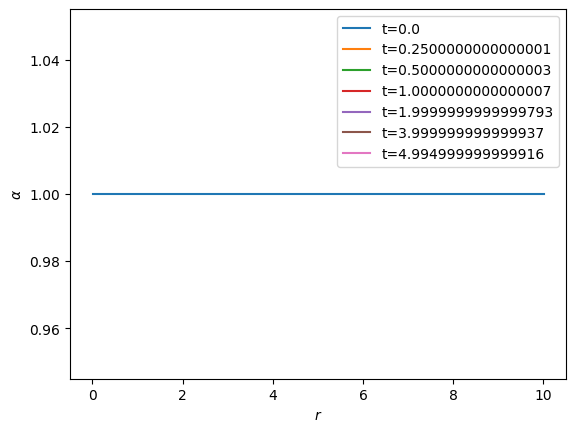

In [74]:
plot_indices = [0, 50, 100, 200, 400, 800, 999]

print(alphas[2])

print(len(ts))
print(len(alphas))

plt.figure()
for idx in plot_indices:
    plt.plot(r, alphas[idx], label='t={}'.format(ts[idx]))

plt.xlabel(r'$r$')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.show()

Antes de tentar resolver o problema de forma "direta" como o que eu estou fazendo acima, eu estava tentando resolver de forma modular/orientada a objeto, porém eu tive que simplificar minha abordagem devido ao prazo. Para não perder todo o meu trabalho (e quem sabe para trabalhar nessa ideia posteriormente), deixarei abaixo o que eu consegui fazer até agora nessa abordagem:

In [ ]:
# Spatial grid variables:

class GridVar:
    '''
    Every variable in the simulation is a scalar function A(r,t), for every time slice these variables can be represented as vectors A_r(t)
    Every variable in the simulation will be defined within the same grid and will have similar behaviors within that grid, so this class
    defines these common properties based on the size of the grid.
    
    Attributes:
        drs ( np.array (N-1, ) ): drs[i]=rs[i+1]-rs[i] up to i=len(rs)-1
        rs ( np.array (N, ) ): Values of r in the interval
        vals ( np.array (N, ) ): Values of the variable for each r

    Methods:
        d_dr(self): Returns the np.array of numerical derivatives of the variable along the grid
        int_dr(self, int0): Returns the np.array of numerical integration along the grid (sets the first element to int0) 
        Dunder methods: __init__, __mul__, __rmul__, __add__.
    '''
    
    def __init__(self, vals, rs):

        self.rs = rs
        self.drs = self.rs[1:]-self.rs[:-1]
        self.vals = vals

    def d_dr(self, bounds = None):
        '''
        Returns a np.array with the spatial derivatives of vals
        If given, bounds has to be a 2-element (number) list, tuple or array
        '''

        diff = np.zeros(len(self.vals))
        
        if bounds == None:
            diff[0] = (self.vals[1]-self.vals[0])/self.drs[0]
            diff[-1] = (self.vals[-1]-self.vals[-2])/self.drs[-1]
        else:
            diff[0], diff[-1] = bounds[0], bounds[1]

        # Central difference algorithm for numerical derivative:

        diff[1:-1] = (self.vals[2:] - self.vals[:-2]) / (2 * self.drs[:-1])
        
        return GridVar(diff, self.rs)

    def int_dr(self, bound):
        '''
        Returns a np.array with the spatial integral of vals, given an initial value integral[0]
        '''
        
        integral = np.zeros(len(self.vals))
        integral[0]=bound
    
        for i in range(len(self.vals)-1):
            integral[i+1]=integral[i]+0.5*self.drs[i]*(self.vals[i]+self.vals[i+1]) #trapezoid rule

        return GridVar(integral, self.rs)

    def __mul__(self, lbda):
        # Behavior under the syntax lbda*instance, lbda can be both a GridVar object or a number
        # Breaks if lbda is a GridVar instance with a different rs array: can only operate on identical grids.
        if isinstance(lbda, GridVar):
            if not np.allclose(lbda.rs, self.rs):
                raise ValueError("You can only multiply GridVars with the exact same r grid!")

        vec = lbda*self.vals
        rs = self.rs

        return GridVar(vec, rs)

    def __rmul__(self, lbda):
        # Behavior under the syntax instance*lbda, so the code doesn't break if instance*number is called

        return self.__mul__(lbda)

    def __add__(self, other):
        # Behavior under the syntax instance1+instance2
        # __radd__ is not necessary, if both objects are GridVar instances, the order of the operation won't change the result
        if isinstance(other, GridVar) and np.allclose(self.rs, other.rs):
            vec = self.vals+other.vals
            rs = self.rs

            return GridVar(vec, rs)
        else:
            raise ValueError("GridVar objects can only sum over other GridVar objects with the exact same r grid.")

    def __truediv__(self, other):
        if isinstance(other, GridVar) and np.allclose(self.rs, other.rs):
            vec = self.vals/other.vals
            rs = self.rs

            return GridVar(vec, rs)
        elif (type(other) == int) or (type(other) == float):
            vec = self.vals/other
            rs = self.rs

            return GridVar(vec, rs)
        else:
            raise ValueError('GridVar can only be divided by numbers, array or other GridVar instance with the same grid (rs)!')

    def __repr__(self):
        return repr(self.vals) #when called is presented as the numpy array

    def __pow__(self, exponent):
        #behavior under syntax instance**exponent
        vec = np.power(self.vals, exponent)
        rs = self.rs

        return GridVar(vec, rs)

In [ ]:
class Grid:
    '''
    Defines the grid itself for each time slice. Contains all variables required to describe a spatial slice. Here we assume the Bona-Lasso
    slicing condition.

    Args:
        rs ( np.array (N, ) ): Values of r 'labeled' in the grid, the user has to be careful with this definition
        Nr (int): Length of rs.
        tDa, tDb, Ka and Kb are assumed to be float numpy arrays shaped (N,).
        tA, tB, lbda and alpha are calculated from the previous variables

    Methods:
        A_calculate(self): Calculates A from tA and psi
        B_calculate(self): Calculates B from tB and psi
        lbda_calculate(self): Calculates lbda from other variables
        alpha_calculate(self, bound): Given a boundary condition, calculates alpha from Dalpha
        Evolution functions evaluate the expressions for d(var)/dt: dtU, dtK, dtDalpha, dtlbda, dtDb, dtKb
        These functions evaluate the hamilton and momentum constraints: Hamilton_const() and Momentum_const()
    '''

    def __init__(self, rs, tDa, tDb, Ka, Kb):

        #grid properties:
        self.rs = rs
        self.Nr = len(rs)
        self.psi = GridVar(psi(rs), rs) #using M=1 for now
        
        #simulation variables:
        self.tDa = GridVar(tDa, rs)
        self.tDb = GridVar(tDb, rs)
        self.Ka = GridVar(Ka, rs)
        self.Kb = GridVar(Kb, rs)

        #obtainable variables:
        self.tA = self.tA_calculate()
        self.tB = self.tB_calculate()
        self.lbda = self.lbda_calculate()
        self.alpha = self.alpha_calculate()
        self.Dalpha = self.Dalpha_calculate()

        self.dr_lnpsi = GridVar(np.log(self.psi.vals), self.rs).d_dr() #this variable is used many times 
        # defining it here may save some time

    def tA_calculate(self):
        return None
        
    def tB_calculate(self):
        return None

    def alpha_calculate(self, bounds=None):
        return None

    def lbda_calculate(self):
        return None

    def Dalpha_calculate(self):
        return None

    def dt_tDa(self):
        # Evolution equation for Da
        return (-2)*self.alpha*(self.Ka*self.Dalpha+self.Ka.d_dr())

    def dt_tDb(self):
        # Evolution equation for Db
        return (-2)*self.alpha*(self.Kb*self.Dalpha+self.Kb.d_dr())

    def dt_Ka(self):
        # Evolution equation for Ka
        mul = self.alpha/((self.psi**4)*self.tA)

        t1 = (self.Dalpha+self.tDb+4*self.dr_lnpsi).d_dr()
        t2 = self.Dalpha**2
        t3 = (self.tDb+4*self.dr_lnpsi)**2
        t4 = (self.Dalpha-self.tDb-4*self.dr_lnpsi)*(self.tDa+4*self.dr_lnpsi)/2
        
        par = t1+t2+t3-t4
        return (-mul)*par

    def dt_Kb(self):
        # Evolution equation for Kb
        mul = self.alpha/(2*(self.psi**4)*self.tA)

        t1 = (self.tDb+4*self.dr_lnpsi).d_dr()
        t2 = self.Dalpha*(self.tDb+4*self.dr_lnpsi)
        t3 = (self.tDb+4*self.dr_lnpsi)**2
        t4 = (self.tDa+4*self.dr_lnpsi)*(self.tDb+4*self.dr_lnpsi)/2
        t5 = (1/self.rs)*(self.tDa-4*self.tDb-2*self.Dalpha-12*self.dr_lnpsi)
        t6 = 2*self.lbda/self.rs
        
        par = t1+t2+t3-t4-t5+t6
        
        tout = self.alpha*self.Kb*(self.Ka+2*self.Kb)
        
        return (-mul)*par+tout

    def dt_lbda(self):
        mult = (2*self.alpha*self.tA)/self.tB
        
        par = self.Kb.d_dr()-(self.tDb+4*self.dr_lnpsi)*(self.Ka-self.Kb)/2

        return mult*par

    def Hamilton_const(self):

        #reescrever em termos das variáveis novas antes de escrever aqui
        
        return -t1+t2+t3+t4+t5-t6

    def Momentum_const(self):
        # Momentum constraint
        t1 = self.Kb.d_dr()
        t2 = (self.Ka-self.Kb)/self.rs
        t3 = (self.Ka-self.Kb)*(self.tDb+4*self.dr_lnpsi)/2
        
        return -t1+t2+t3

Seguem alguns testes das classes definidas acima:

In [ ]:
rs = 1+np.arange(10)
tDa, tDb = np.zeros(len(rs)), 0.5+np.zeros(len(rs))
Ka, Kb = 1.+np.zeros(len(rs)), 2.+np.zeros(len(rs))

test_grid = Grid(rs, tDa, tDb, Ka, Kb)

print('Operations test:')
print('Sum: ', test_grid.tDa+test_grid.tDb)
print('Multiplication: ', test_grid.tDb*test_grid.Kb)
print('Division: ', test_grid.Kb/test_grid.tDb)
print('3+ term multiplication: ', test_grid.tDb*test_grid.Ka*test_grid.Kb)
print('Power: ', test_grid.Kb**(2.5))

grid_tDa = GridVar(np.arange(len(rs)), rs)
print('\nRadial derivative & integral test:')
print('New tDa: ', grid_tDa)
d_tDa = grid_tDa.d_dr()
print('Derivative: ', d_tDa)
int_tDa = grid_tDa.int_dr(0.)
print('Integral: ', int_tDa)

In [ ]:
# plotting the integral is more useful:
# A parabola is expected

plt.figure()
plt.plot(rs, int_tDa.vals)
plt.xlabel('r')
plt.ylabel(r'$\tilde{D}_a$')
plt.show()

In [ ]:
class SwarzschildRun:
    '''
    Given a starting Grid object and (other parameters), this class can be used to run and handle data throughout a run and (hopefully)
    import and export data using pandas for practicality.

    Attributes:
        startGrid (Grid): Initial slice of the simulation
        history (dict):  
        
    Methods:
        
    '''

    def __init__(self, startGrid):
        self.slice = self.startGrid